<a href="https://colab.research.google.com/github/brahma2024/Deep-Implicit-Layers/blob/main/ch1_1_Deep_Implicit_Layer_Fixedpoint_through_NewtonRootFinding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Newton's method to finding the Fixedpoint Layer

**Goal**

Goal of the fixed point iteration is to find a z such that
    
    z = tanh(Wz + x)

One way we tried above was to simply iterate this equation, in hope of it converging. But its not the only approach, in the code below we will apply the Newton's method, to find the solution more efficiently.

**Newton's method is a root-solving technique (https://www.youtube.com/watch?v=cOmAk82cr9M)**

- For some function g:Rn→Rn, if we wish to find a root g(z)=0, then Newton’s method repeats the update  

> z:=z−((∂g/∂z)**−1) * g(z)



where ∂g/∂z denotes the Jacobian of f with respect to z

**Next Step**

- we are attempting to find the root of the equation g(x,z)=0, where

    g(x,z) = z − tanh(Wz+x)

Then our Jacobian is given by

    ∂g/∂z = I − diag(tanh′(Wz+x))W

where tanh' denotes the derivative of the tanh function, given by

    tanh′(x) = sech2(x)

Let's see what an implementation of Newton’s method looks like in code.

In [1]:
import torch
import torch.nn as nn
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Implementing TanhInputLayer(nn.Module)
# instantiating nn.Module class from Pytorch

class TanhNewtonLayer(nn.Module):

  def __init__(self, out_features, tol=1e-5, max_iter=50):
    super().__init__()
    self.linear = nn.Linear(out_features, out_features, bias=False) # linear layer with just weights no bias
    self.tol = tol
    self.max_iter = max_iter
    self.iterations = 0

  def forward(self, x):
    # initialize output z to be zero
    z = torch.tanh(x) # (B, C)
    # print(f'{z.shape=}, post-tanh: {z[0]=}, {z.view(-1).shape=}')

    # visualize tanh layer distribution
    # flatten z into a 1D tensor = 10 * 50 and then convert it into list
    plt.hist(z.view(-1).tolist(), 50)

    # print(f'Initiating Forward Pass: starting Iterations!')
    while self.iterations < self.max_iter:
      z_linear = self.linear(z) + x # (B, C)
      # print(f'\n Linear Transformation: {z_linear.shape=}')

      g = z - torch.tanh(z_linear) # (B, C) | the difference between the current value of z and the hyperbolic tangent of the linear transformation plus the input
      # print(f'{g[0]=}')
      self.err = torch.norm(g) # assess the residual error for each sample in the batch
      # print(f'{self.err=}')

      if self.err < self.tol:
          break

      # Calculate Jacobian J
      I = torch.eye(z.shape[1], device=z.device).unsqueeze(0) # identity Matrix (1, C, C)
      # print(f'{I.shape=}')

      # for each batch, each element calculate the element-wise derivative of g with respect to z
      sech2_z_linear = (1 / torch.cosh(z_linear)**2) # (B, C)
      # print(f'Before singleton dim added at position 2: {sech2_z_linear.shape=}')

      # add a spurious dim, for purpose of broadcasting when calculating the adjustment term
      sech2_z_linear = sech2_z_linear.unsqueeze(2) # (B, C, 1) | element-wise
      # print(f'After singleton dim added at position 2: {sech2_z_linear.shape=}')

      # so for each of the 10 vector from the Batch dim in z, has C feature-dims gets transformed by a weights matrix in linear layer
      # weights matrix is (C, C) so, each vector in batch-dim in z is transformed to a new vector-space with dimensions C
      # add a spurious dim at 0th position for purpose of broadcasting when calculating the adjustment term
      weights = self.linear.weight.unsqueeze(0) # (1, C, C)
      # print(f'{weights.shape=}')

      # adjustment term is, for each batch  ==> (derivative of each element in g wrt to each element in z) * weights
      adjustment_term = sech2_z_linear * self.linear.weight.unsqueeze(0) # (B, C, C)
      # print(f'{adjustment_term.shape=}')

      # Identity matrix is broadcasted across adjustment_term to calculate the gradient matrix (jacobian)
      # jacobian matrix is block-diagonal matrix
      J = I - adjustment_term # (B, C, C)
      # print(f'{J.shape=}')

      # Newton step
      # torch.linalg.solve is a function in PyTorch that solves a linear system Solves 𝐽⋅Δ𝑧 = 𝑔, for Δ𝑧
      # remember J is Δg/Δ𝑧 i.e. change in g wrt to z (element-wise)
      # Goal is to find Δ𝑧, by solving the linear system 𝐽⋅Δ𝑧 = 𝑔, (J, g are known)

      # Prepare g for the solver
      g_unsqueezed = g.unsqueeze(2)  # Shape: (B, C, 1)

      # Solve the linear system
      delta_z = torch.linalg.solve(J, g_unsqueezed)  # Shape: (B, C, 1)

      # Squeeze the result
      delta_z_squeezed = delta_z.squeeze(2)  # Shape: (B, C)

      # z is updated with the Newton step 𝑧 − Δ𝑧
      z = z - delta_z_squeezed # shape: (B, C)
      #print(f'{z.shape=}')
      print(f'{self.iterations=} | {self.err=}')
      self.iterations += 1

    # print(f'Completed {self.iterations} iterations/{self.max_iter} | next updating z')
    # Check final residuals and zero-out large errors
    g = z - torch.tanh(self.linear(z) + x)
    mask = torch.norm(g, dim=1) > self.tol # zero out any row where output > tolerance
    # z[mask, :] = 0 # ensure that the final output z meets a certain quality criterion
    z = torch.where(mask.unsqueeze(1), torch.zeros_like(z), z) # replace in-place operation with out-of-place operation

    return z

# Solve for random sampled data

/usr/local/lib/python3.10/dist-packages/torch/autograd/profiler.py:228: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


self.iterations=0 | self.err=tensor(13.2736, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=1 | self.err=tensor(0.5596, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=2 | self.err=tensor(0.0010, grad_fn=<LinalgVectorNormBackward0>)
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                          Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::sub         2.61%       5.155ms         2.61%       5.155ms     468.636us       3.01 Mb       3.01 Mb            11  
        aten::_linalg_solve_ex         2.92%       5.765ms        49.18%      96.945ms      32.315ms       2.98 Mb       2.98 Mb             3  
                     aten::mul 

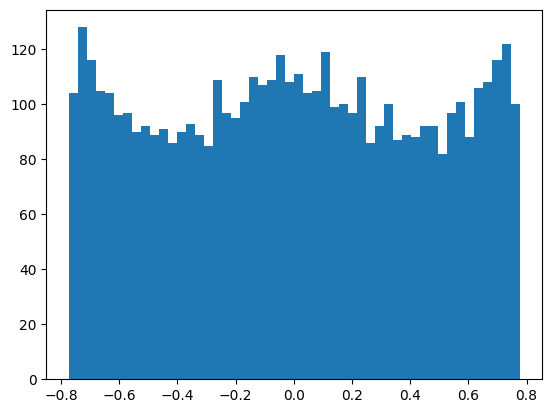

In [4]:
N = 100  # Number of samples / Batches
D = 50   # Number of dimensions / Features

X = torch.tensor(np.linspace(-10, 10, N)).reshape(-1, 1).repeat(1, D).float()
X += torch.tensor(np.sin(np.linspace(0, 2*np.pi, N))).reshape(-1, 1).repeat(1, D).float()
X += torch.randn(N, D) * 0.1  # Adding some noise
X /= torch.sqrt(torch.tensor(N)) # normalizes the extreme values in input, in order to not saturate the tanh output

# X: A batch of N vectors, each with D dimensions/features, generated from a standard normal distribution
# X = torch.randn(N, D)

# Create layer
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
  layer = TanhNewtonLayer(out_features = D)
  Z = layer(X)
  prof.step()

# Print profiling results
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

print(f'Terminated after {layer.iterations} iterations with error {layer.err}')

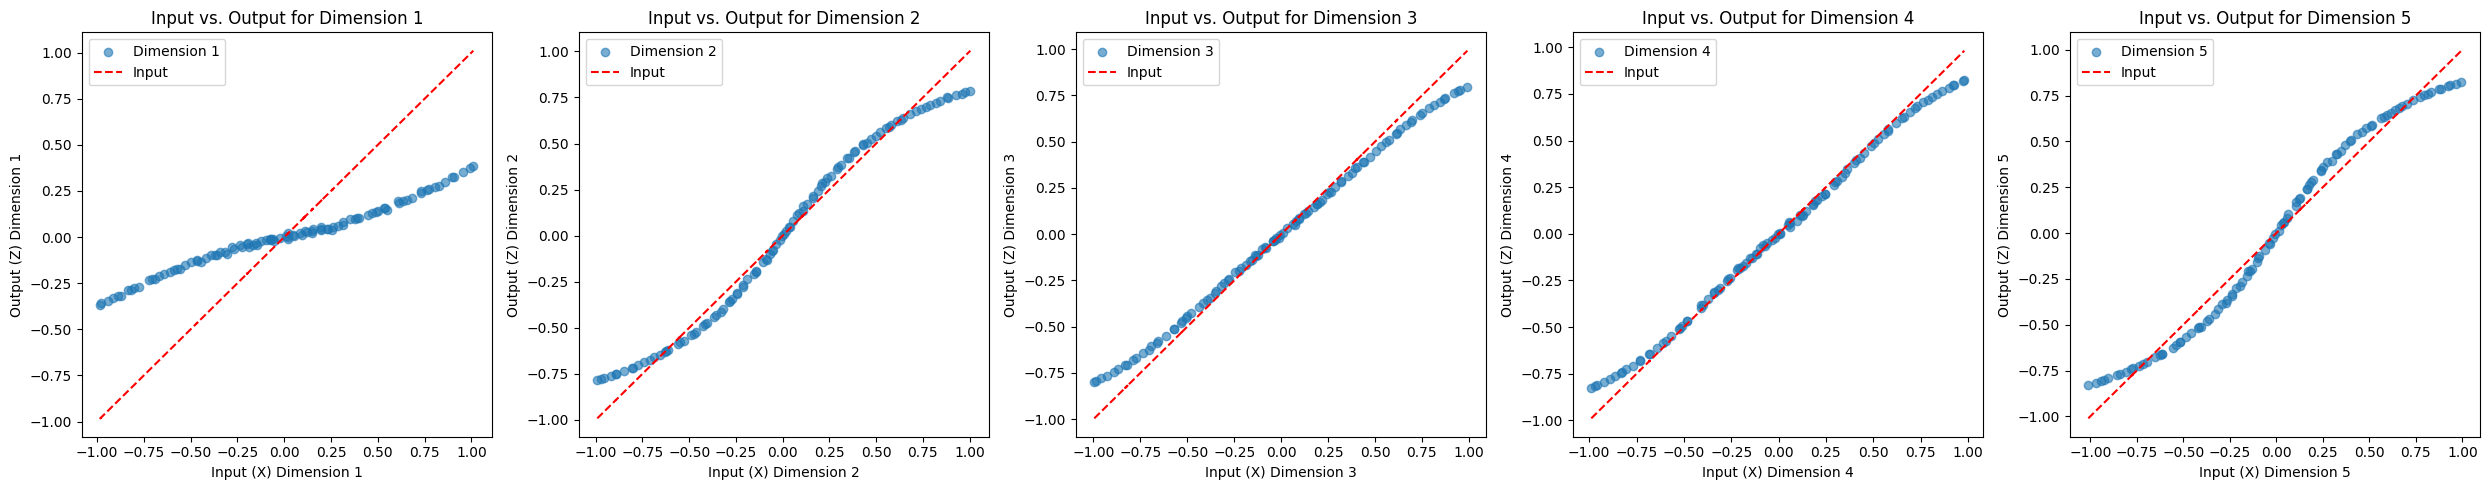

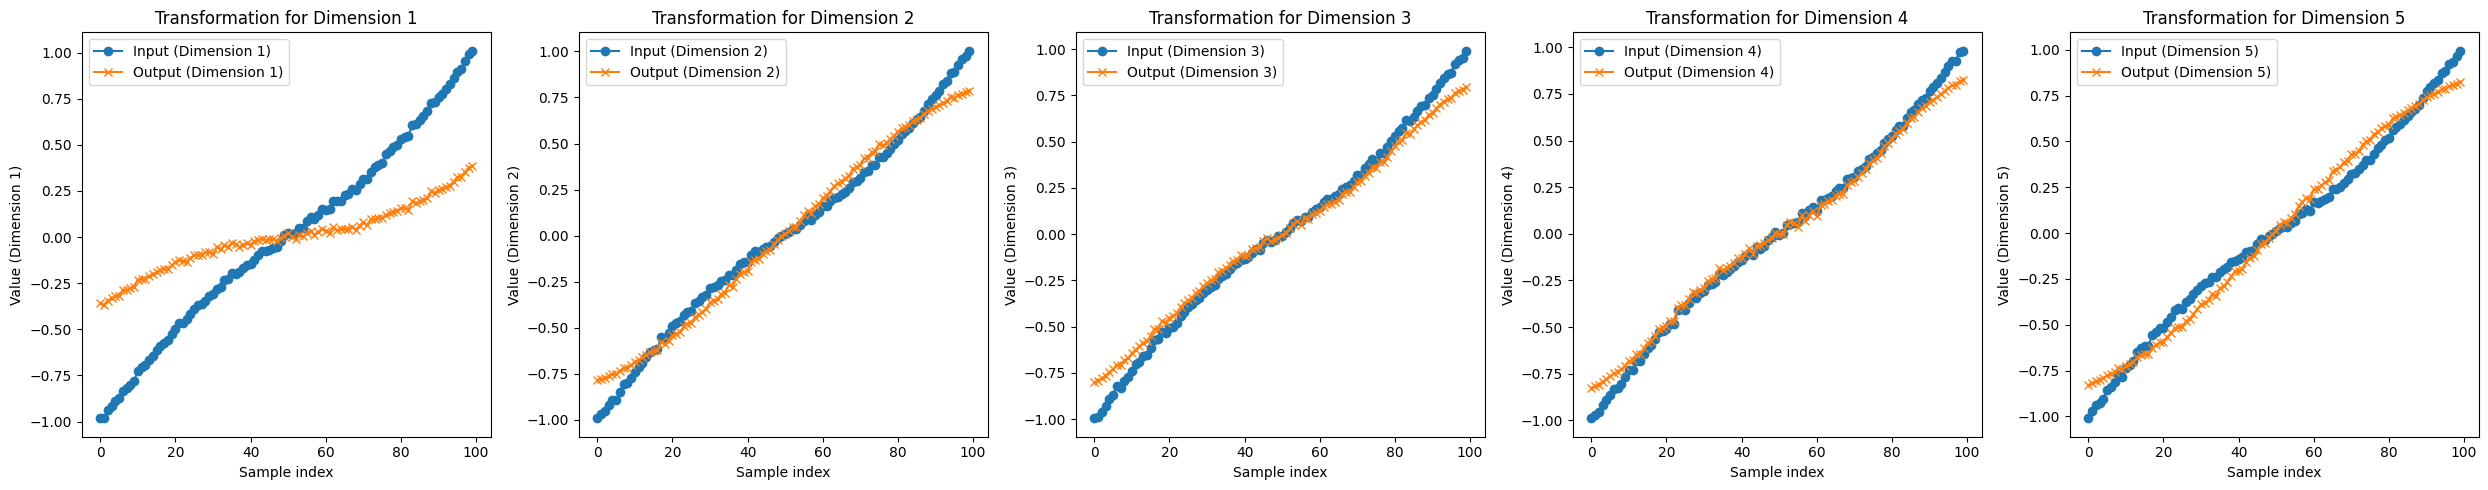

In [5]:
# Plot input vs. output for a few dimensions
plt.figure(figsize=(25, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.scatter(X[:, i].detach().numpy(), Z[:, i].detach().numpy(), label=f'Dimension {i+1}', alpha=0.6)
    plt.plot(X[:, i].detach().numpy(), X[:, i].detach().numpy(), 'r--', label='Input')
    plt.xlabel(f'Input (X) Dimension {i+1}')
    plt.ylabel(f'Output (Z) Dimension {i+1}')
    plt.title(f'Input vs. Output for Dimension {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

# Visualize the transformation of specific input features
plt.figure(figsize=(25, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(range(X.shape[0]), X[:, i].detach().numpy(), 'o-', label=f'Input (Dimension {i+1})')
    plt.plot(range(X.shape[0]), Z[:, i].detach().numpy(), 'x-', label=f'Output (Dimension {i+1})')
    plt.xlabel('Sample index')
    plt.ylabel(f'Value (Dimension {i+1})')
    plt.title(f'Transformation for Dimension {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()

# Solve for MNIST Dataset
- similar to how we solved for MNIST dataset through multiple iterations to find a fixedpoint layer in ch1.0

In [6]:
# import the MINST dataset and data loaders
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
# download the MNIST dataset from torchvision.datasets
mnist_train = datasets.MNIST(".", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(".", train=False, download=True, transform=transforms.ToTensor())

# create a DataLoader
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5934188.12it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1129891.74it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2367957.23it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3449308.12it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
# a generic function for running a single epoch (training or evaluation)
from tqdm.notebook import tqdm

def epoch(loader, model, opt=None, monitor=None):
  total_loss, total_err, total_monitor = 0., 0., 0.

  # initialize a loss function
  # criterian = nn.CrossEntropyLoss() # This is an object-oriented approach where you create an instance of the loss function and then call it with your predictions and targets.
  model.eval() if opt is None else model.train()

  # tqdm is a Python library that provides a fast, extensible progress bar for loops and other iterable processes
  # tqdm iterates over the data loader
  # train_loader has mnist_dataset_size = 60000 and batch_size = 100
  for X, y in tqdm(loader, leave=False):
    X, y = X.to(device), y.to(device) # move data and labels to the specified device

    # Extract the first element of the tuple if it's a tuple, otherwise use the output directly
    yp = model(X) # label prediction

    # calculate the loss
    # loss = criterian(yp, y)
    loss = nn.CrossEntropyLoss()(yp, y)

    # run model optimizer | SGD in this case
    if opt:
      for param in model.parameters():
        param.grad = None # set the gradients of the model parameters to zero
      loss.backward() # calculate the gradient in the backward pass

      # safety check: ensuring there are no NaN values in the gradients of any of the model parameters
      if sum(torch.sum(torch.isnan(p.grad)) if p.grad is not None else 0 for p in model.parameters()) == 0: # execute optimization step only if no gradient has NaN
        opt.step() # applies - lr_rate * grad update on model parameters

    total_err += (yp.max(dim=1)[1] != y).sum().item() # Computes the number of misclassified samples in the batch
    total_loss += loss.item() * X.shape[0] # calculates the -ve loglikelihood estimate

    # The monitor parameter is an optional callable that allows you to track additional metrics beyond the loss and error
    # - The norm of the model parameters.
    # - Custom evaluation metrics such as precision, recall, F1 score, etc.
    # - Any other diagnostic information that can help understand the model's performance.
    if monitor is not None:
      total_monitor += monitor(model)

  return total_err /  len(loader.dataset), total_loss / len(loader.dataset), total_monitor / len(loader)

78400
100
10000
1000
10


  0%|          | 0/600 [00:00<?, ?it/s]

self.iterations=0 | self.err=tensor(10.7504, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=1 | self.err=tensor(0.2421, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=2 | self.err=tensor(0.0003, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=3 | self.err=tensor(10.8662, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=4 | self.err=tensor(0.2500, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=5 | self.err=tensor(0.0003, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=6 | self.err=tensor(10.9415, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=7 | self.err=tensor(0.2628, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=8 | self.err=tensor(0.0003, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=9 | self.err=tensor(10.6692, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=10 | self.err=tensor(0.2331, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=11 | self.err=tensor(0.0002, grad_fn=<LinalgVectorNormBackward0>)
self.iterations=12 | s

  0%|          | 0/100 [00:00<?, ?it/s]

Train Error: 0.8856, Loss: 2.2980, Newton Iters: 97.31 | Test Error: 0.8865, Loss: 2.3015, Newton Iters: 100.00


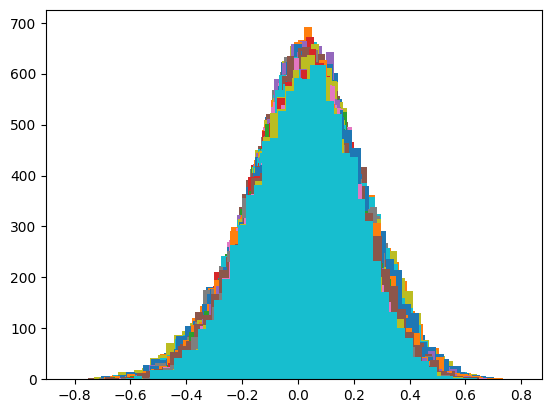

In [9]:
torch.manual_seed(22)
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 100),
                      TanhNewtonLayer(100, max_iter=100),
                      nn.Linear(100, 10),
).to(device)

model_opt = torch.optim.SGD(model.parameters(), lr=1e-2)

for p in model.parameters():
  print(p.nelement())

for i in range(1):
  if i == 1:
    model_opt.param_groups[0]['lr'] = 1e-3

  train_err, train_loss, train_fpiter = epoch(train_loader, model, opt=model_opt, monitor=lambda x: x[2].iterations)
  test_err, test_loss, test_fpiter = epoch(test_loader, model, opt=None, monitor=lambda x: x[2].iterations)
  print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, Newton Iters: {train_fpiter:.2f} | " +
          f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, Newton Iters: {test_fpiter:.2f}")

# Limitation with the above Newton-Raphson root finding approach
1. The Newton root-finding approach is noticably slower than the the simpler fixed point iteration method above
  - Even though the number of iterations needed is much smaller that for fixed point iteration, each individual iteration is also much slower, as it involves forming and inverting a separate (in this case, 100×100) Jacobian matrix for each sample in the minibatch
  - **In pratice**, an exact Newton method is rarely used, and instead we can employ quasi-Newton methods to improve convergence over the standard fixed point iteration, while also improving wall clock time

2. In the implementation above, Newton’s method is directly used within an automatic differentiation toolkit, there are a few large downsides to this method
  - as with the fixed point iteration, the automatic differentiation tool will need to save the intermediate iterates of the hidden units, which means
  - we also need to store in memory the intermediate iterates of the Jacobian terms as well, which drastically increases memory consumption even for the case where we could store and invert the full Jacobian
  - backpropagation through repeated inverses can be a numerically unstable routine: if an inverse is close to singular then even if the forward pass converges properly, the backward pass can still generate numerical errors in the graidents. Indeed, you will notice that we included a “NaN check” in our epoch(). If we did not do this, then for Newton’s method the approach will immediately fail: if you check, you will see that around 5% of the updates actually have NaN values in the gradient, due to conditioning of the Jacobians, which is also what causes the method to actually converge slower than the fixed point iteration version.

3. Just to note, this is able to nicely coverge more quickly than the fixed point iteration, but with the (major) caveat that we now have to solve a linear system at each iteration

#**Most Important takeaway**

      ∂z⋆(x)∂x=−(∂g(x,z⋆)/∂z⋆)**−1 * ∂g(x,z⋆)/∂x

Being able to derive this formula, leads to a very practical consequence. The formula gives a form for the necessary Jacobian without needing to backpropagate through the method used to obtain the fixed point. In other words, it doesn’t matter at all how we compute the zero of the function (whether via fixed point iteration, Newton’s method, or quasi-Newton methods). All that matters is finding the fixed point (using whatever technique you want), at which point we can directly compute the necessary Jacobians using this analytical form (or more precisely, compute the backward pass, which often will not require explicit computation of the Jacobian in practice). No intermediate terms of the iterative method used to compute the fixed point need to be stored in memory (making the methods much more memory efficient), and there is no need to unroll the forward computations within an automatic differentiation layer.

# Visualizing the computational graph of the Neural Network above

In [12]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

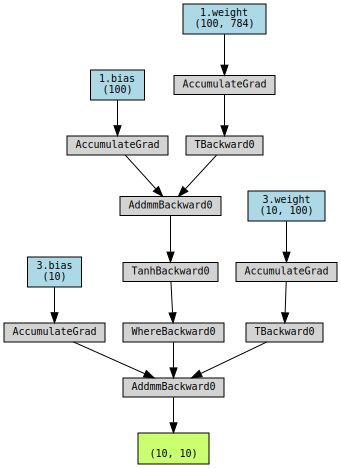

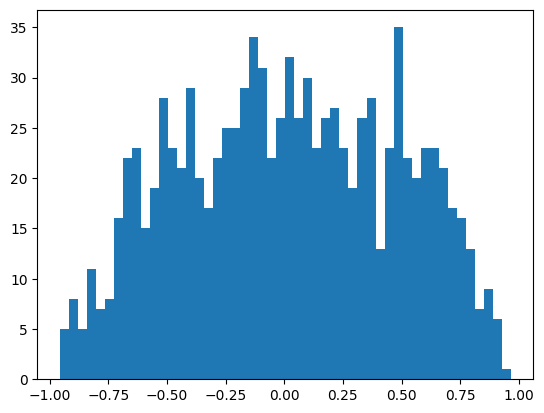

In [17]:
# Visualizing the computational graph of the network above
from torchviz import make_dot
import networkx as nx

input_tensor = torch.randn(10, 784)

# Perform a forward pass to build the computational graph
output = model(input_tensor)

# Visualize the computational graph
graph = make_dot(output, params=dict(model.named_parameters()))

graph